## JSON to CSV

In [6]:
import json
import gzip
import csv


def curr_time():
    import datetime, pytz
    nyc_curr = datetime.datetime.now(pytz.timezone('US/Eastern'))
    return nyc_curr.strftime('%Y-%m-%d %H:%M:%S')


def safe_read(line,col):
    try:
        return line[col]
    except:
        return None
        
        
def json2csv(table_name):
    input_file = './data/{0}.json.gz'.format(table_name)
    output_file = './data/{0}.csv'.format(table_name)

    print('Processing {0}.json.gz: {1}'.format(table_name,curr_time()))
    with gzip.open(input_file, 'r') as file_in:
        with open(output_file, 'w', encoding='utf-8') as file_out:
            writer = csv.writer(file_out, delimiter=',', escapechar='\\')
            writer.writerow(['reviewerID','asin','helpful','reviewText',
                             'overall','summary','unixReviewTime','reviewTime'])
            for line in file_in:
                review = eval(line)
                reviewerID = safe_read(review,'reviewerID')
                asin = safe_read(review,'asin')
                reviewerName = safe_read(review,'reviewerName')
                helpful = safe_read(review,'helpful')
                # it can work over a CSV, but does not respect escaped commas which produces a bad result
                reviewText = safe_read(review,'reviewText')
                if reviewText is not None:
                    reviewText = reviewText.replace('"', '\"').strip()
                overall = safe_read(review,'overall')
                summary = safe_read(review,'summary')
                unixReviewTime = safe_read(review,'unixReviewTime')
                reviewTime = safe_read(review,'reviewTime')
                writer.writerow([reviewerID,asin,helpful,reviewText,
                                 overall,summary,unixReviewTime,reviewTime])
    print('Done!',curr_time())

In [12]:
json2csv('reviews_Baby_5')

Processing reviews_Baby_5.json.gz: 2019-06-27 20:10:06
Done! 2019-06-27 20:10:18


In [13]:
for table in ['reviews_Books_5', 'reviews_Electronics_5', 'reviews_Sports_and_Outdoors_5', 'reviews_Video_Games_5']:
    json2csv(table)

Processing reviews_Books_5.json.gz: 2019-06-27 20:10:18
Done! 2019-06-27 20:24:47
Processing reviews_Electronics_5.json.gz: 2019-06-27 20:24:47
Done! 2019-06-27 20:27:16
Processing reviews_Sports_and_Outdoors_5.json.gz: 2019-06-27 20:27:16
Done! 2019-06-27 20:27:40
Processing reviews_Video_Games_5.json.gz: 2019-06-27 20:27:40
Done! 2019-06-27 20:28:06


## Feature Extraction

### Entity and Sentiment Detection

In [1]:
import pandas as pd

In [2]:
# read data
review_df = pd.read_csv('./data/reviews_Baby_5')
review_df.sample(3)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
72000,AMUT3CJD53M7N,B002GUHWV2,"[0, 0]",I bought it in conjunction with a munchie mug ...,5.0,works perfect,1365292800,"04 7, 2013"
35262,A5RQIPJ3UWLJH,B000O7SR18,"[0, 0]","This sheet is a good fabric, but is too small ...",3.0,"Good fabric, doesn't fit a graco",1373760000,"07 14, 2013"
103901,A2EXX1OF08ALOT,B0043D28AU,"[0, 0]","may my baby is too young at 9 months, but she ...",3.0,baby got tired of it,1377302400,"08 24, 2013"


In [3]:
# check null values
review_df.isnull().sum()

reviewerID         0
asin               0
helpful            0
reviewText        60
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [4]:
# fill null with empty string
review_df = review_df.fillna('')
review_df.isnull().sum().sum()

0

- Split reviewText to Paragragh List

In [5]:
review_df['reviewText'].map(type).value_counts()

<class 'str'>    160732
Name: reviewText, dtype: int64

In [6]:
def paragraph_split(x):
    p = x.strip().replace('.  ','.|||').replace('!  ','!|||').replace('?  ','?|||')
    return p.split('|||')

In [7]:
%%time
review_df['reviewParagraphs'] = review_df['reviewText'].map(paragraph_split)
review_df['paragraph_num'] = review_df['reviewParagraphs'].map(len)

CPU times: user 1.52 s, sys: 87.3 ms, total: 1.61 s
Wall time: 1.68 s


In [8]:
review_df.sample(3)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewParagraphs,paragraph_num
62310,A2ZEXKFLKF3TSK,B001OC62U0,"[0, 0]",The mirror serves its purpose- could be a litt...,3.0,still needs some tweaking,1313020800,"08 11, 2011",[The mirror serves its purpose- could be a lit...,1
132753,A3OZ39B0BKTP3Z,B006OJIJVI,"[1, 1]",This was the only gate that worked for my bani...,4.0,"Hard to install, but needed.",1382659200,"10 25, 2013",[This was the only gate that worked for my ban...,4
9546,A1Q011AJ259PCY,B000134XZE,"[0, 0]",Does a good job of keeping the odour down.I us...,4.0,does the job,1380412800,"09 29, 2013",[Does a good job of keeping the odour down.I u...,1


- POS Tagging & Sentiment Detection

In [9]:
import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from collections import Counter


from ast import literal_eval
flatten = lambda l: [item for sublist in l for item in sublist]
str_eval = lambda inp: literal_eval(inp) if type(inp)==str else inp


# regexp = RegexpTokenizer(r'\w+')
PS = PorterStemmer()
WNL = WordNetLemmatizer()


# nltk.help.upenn_tagset()
entity_tags = ['NN','NNS','NNP','NNPS']
senti_tags = ['JJ','JJR','JJS','RB','RBR','RBS']


def review_pos_tag(review_paragraphs):
    results = []
    for review_text in review_paragraphs:
        sentences = sent_tokenize(review_text)
        tokens = flatten([word_tokenize(s) for s in sentences])
        stemmed_words = [PS.stem(w.lower()) for w in tokens if w.isalpha()]
        results.append(dict(Counter(pos_tag(stemmed_words))))
    return results


def penn_to_wn(tag):
    # Convert between the PennTreebank tags to simple Wordnet tags
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def get_sentiment(word,tag):
    # returns list of pos neg and objective score. 
    # But returns empty list if not present in senti wordnet.
    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return ()
    lemma = WNL.lemmatize(word, pos=wn_tag)
    if not lemma:
        return ()
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return ()
    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())
    if swn_synset.pos_score() >= swn_synset.neg_score() and swn_synset.pos_score() >= swn_synset.obj_score():
        swn_type = swn_synset.pos_score()
    elif swn_synset.neg_score() >= swn_synset.pos_score() and swn_synset.neg_score() >= swn_synset.obj_score():
        swn_type = -swn_synset.neg_score()
    else:
        swn_type = 0
    return (word, swn_type)


def map_sentiment(pos_tag_data):
    pos_tag_data = str_eval(pos_tag_data)
    results = []
    for pt in pos_tag_data:
        senti_val = {}
        for w,t in pt.items():
            senti = get_sentiment(w[0],w[1]) 
            if len(senti) > 0 and senti[1] != 0:
                senti_val[senti] = t
        results.append(senti_val)
    return results

In [19]:
%%time
review_df['pos_tag'] = review_df['reviewParagraphs'].map(review_pos_tag)

CPU times: user 22min 31s, sys: 11.6 s, total: 22min 42s
Wall time: 22min 42s


In [21]:
review_df.to_csv('./data/reviews_Baby_5_step_0.csv',
                 encoding='utf-8',
                 index=False)

In [22]:
%%time
review_df['wn_senti'] = review_df['pos_tag'].map(map_sentiment)

CPU times: user 1min 53s, sys: 605 ms, total: 1min 54s
Wall time: 1min 55s


In [24]:
def entity_split(pos_tag):
    pos_tag = str_eval(pos_tag)
    return [{w[0]:t} for pt in pos_tag for w,t in pt.items() if w[1] in entity_tags]


def neutral_senti_split(pos_tag, wn_senti):
    pos_tag, wn_senti = str_eval(pos_tag), str_eval(wn_senti)
    results = []
    for pt,wn in zip(pos_tag, wn_senti):
        wn = {w[0]:c for w,c in wn.items() if w[1] != 0}
        netural_dt = {w[0]:c for w,c in pt.items() 
                      if w[0] not in wn.keys() and w[1] in senti_tags}
        results.append(netural_dt)
    return results


def senti_senti_split(wn_senti,entity,neutral_senti):
    wn_senti, entity, netrual_senti = str_eval(wn_senti), str_eval(entity), str_eval(neutral_senti)
    results = []
    for w,e,n in zip(wn_senti, entity, neutral_senti):
        results.append({w[0]:c for w,c in w.items() if w[0] not in e.keys() and w[0] not in n.keys()})
    return results

In [25]:
%%time
review_df['entity'] = review_df['pos_tag'].map(entity_split)
review_df['neutral_senti'] = review_df[['pos_tag','wn_senti']].apply(lambda x: neutral_senti_split(*x), axis=1)
review_df['senti_senti'] = review_df[['wn_senti','entity', 'neutral_senti']].apply(lambda x: senti_senti_split(*x), axis=1)

CPU times: user 17.5 s, sys: 904 ms, total: 18.4 s
Wall time: 18.4 s


In [28]:
review_df.sample(3)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewParagraphs,paragraph_num,pos_tag,wn_senti,entity,neutral_senti,senti_senti
34932,A38PT5535A55EY,B000O3GCFU,"[0, 0]",Thermos Foogo Leak Proof Stainless Steel Food ...,5.0,Good to keep temprature,1386460800,"12 8, 2013",[Thermos Foogo Leak Proof Stainless Steel Food...,1,"[{('thermo', 'NN'): 1, ('foogo', 'NN'): 1, ('l...","[{('good', 0.75): 1, ('help', 0.5): 1}]","[{'thermo': 1}, {'foogo': 1}, {'leak': 1}, {'p...",[{}],"[{'good': 1, 'help': 1}]"
8289,AQACASMVSDOVR,B00009ZIKH,"[3, 3]",I like the idea of this mobile and would have ...,2.0,"Good idea, bad implementation",1312848000,"08 9, 2011",[I like the idea of this mobile and would have...,1,"[{('i', 'NN'): 1, ('like', 'IN'): 2, ('the', '...","[{('better', 0.875): 1, ('poor', -0.875): 1, (...","[{'i': 1}, {'idea': 1}, {'mobil': 2}, {'thing'...","[{'thi': 1, 'littl': 1, 'whole': 1, 'straight'...","[{'better': 1, 'poor': 1, 'higher': 1}]"
119659,A3AKUEMQGMPTA9,B004W93MFK,"[0, 0]",Give a little two year old a step stool & this...,5.0,works like a charm!,1390176000,"01 20, 2014",[Give a little two year old a step stool & thi...,3,"[{('give', 'VB'): 1, ('a', 'DT'): 3, ('littl',...","[{('stool', -0.5): 1, ('hand', 0.5): 1}, {('no...","[{'littl': 1}, {'year': 1}, {'step': 1}, {'sto...","[{'old': 1, 'big': 1}, {'faucet': 1, 'too': 1,...","[{'stool': 1, 'hand': 1}, {'not': 1}, {}]"


In [29]:
# check null values
review_df.isnull().sum()

reviewerID          0
asin                0
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
reviewParagraphs    0
paragraph_num       0
pos_tag             0
wn_senti            0
entity              0
neutral_senti       0
senti_senti         0
dtype: int64

In [30]:
review_df.to_csv('./data/reviews_Baby_5_step_1.csv',encoding='utf-8',index=False)

### Mutual Information: Entity-Sentiment Pairs

In [31]:
import itertools 
from collections import Counter
import pandas as pd
from ast import literal_eval
flatten = lambda l: [item for sublist in l for item in sublist]
str_eval = lambda inp: literal_eval(inp) if type(inp)==str else inp


review_df = pd.read_csv('./data/reviews_Baby_5_step_1.csv')


def word_extract(pos_tag):
    pos_tag = str_eval(pos_tag)
    return [w[0] for pt in pos_tag for w,c in pt.items()]


all_words = review_df['pos_tag'].map(word_extract).tolist()
all_words_freq = Counter(itertools.chain.from_iterable(all_words))
all_words_freq['perfect']

15094

In [32]:
all_words_cnt = sum(all_words_freq.values())
all_words_cnt

11964893

In [33]:
def es_pair_detection(entity,senti_senti,neutral_senti):
    entity, senti_senti, neutral_senti = str_eval(entity), str_eval(senti_senti), str_eval(neutral_senti)
    results = []
    for en, se, ne in zip(entity, senti_senti, neutral_senti):
        entity_words = list(en.keys())
        se.update(ne)
        senti_words = list(se.keys())
        es_pairs = {}
        for e,s in itertools.product(entity_words, senti_words):
            es_pairs[(e,s)] = min([en[e],se[s]])
        results.append(es_pairs)
    return results

In [34]:
%%time
review_df['es_pairs'] = review_df[['entity','senti_senti','neutral_senti']].apply(lambda x: es_pair_detection(*x), axis=1)

CPU times: user 9.1 s, sys: 316 ms, total: 9.41 s
Wall time: 9.41 s


In [38]:
print(review_df[review_df['paragraph_num']>1].sample(1)['es_pairs'])

159497    [{('product', 'sturdier'): 1, ('product', 'mos...
Name: es_pairs, dtype: object


In [40]:
review_df.to_csv('./data/reviews_Baby_5_step_2.csv', encoding='utf-8', index=False)

In [41]:
def es_pair_freq(es_pairs):
    results_dict = {}
    for es, c in [(es,es_dict[es]) for es_dict in es_pairs for es in es_dict]:
        if es not in results_dict:
            results_dict[es] = c
        else:
            results_dict[es] = results_dict[es] + c
    return results_dict

In [43]:
%%time
temp_es_all = review_df['es_pairs'].map(es_pair_freq).tolist()
es_pairs_all = es_pair_freq(temp_es_all)

CPU times: user 3.88 s, sys: 328 ms, total: 4.21 s
Wall time: 4.2 s


In [46]:
pd.DataFrame(es_pairs_all.items()).to_csv('./data/Baby_5_es_pairs_all.csv', index=False)

In [51]:
import math

def es_mi_calc(entity, senti):
    p_e = all_words_freq[entity]/all_words_cnt
    p_s = all_words_freq[senti]/all_words_cnt
    p_es = es_pairs_all[(entity, senti)]/all_words_cnt
    if p_e*p_s == 0:
        print(entity, senti)
    else:
        return p_es * math.log(p_es/(p_e*p_s))

In [52]:
%%time
es_pairs_mi = {k:es_mi_calc(k[0],k[1]) for k,v in es_pairs_all.items()}

CPU times: user 942 ms, sys: 32 ms, total: 974 ms
Wall time: 971 ms


In [53]:
pd.DataFrame(es_pairs_mi.items()).to_csv('./data/Baby_5_es_pairs_mi.csv', index=False)

### Adjusted Weights' Calculation

- adjusted_weights = (the number of es pair in a review / the number of sentiment word in the common paragraphs in a review) * log(the number of paragraphs in a review/the number of paragraphs the word appears) * (1 + log(1 + express_degress * the number of sentiment words/the number of paragraphs in a review))

In [54]:
review_df.head(1)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewParagraphs,paragraph_num,pos_tag,wn_senti,entity,neutral_senti,senti_senti,es_pairs
0,A1HK2FQW6KXQB2,097293751X,"[0, 0]",Perfect for new parents. We were able to keep ...,5.0,Awesine,1373932800,"07 16, 2013",[Perfect for new parents. We were able to keep...,1,"[{('perfect', 'NN'): 1, ('for', 'IN'): 2, ('ne...","[{('all', 0.5): 1}]","[{'perfect': 1}, {'parent': 1}, {'track': 1}, ...","[{'new': 1, 'first': 1, 'half': 1, 'right': 1}]","[{'all': 1, 'new': 1, 'first': 1, 'half': 1, '...","[{('perfect', 'all'): 1, ('perfect', 'new'): 1..."


In [67]:
def weight_calc(es_pairs, paragraph_num, entity, neutral_senti, senti_senti):
    es_pairs, entity, neutral_senti, senti_senti = str_eval(es_pairs), str_eval(entity), str_eval(neutral_senti), str_eval(senti_senti)
    
    # ni,j dict
    review_es_pairs = es_pair_freq(es_pairs) 
    
    # nj dict, sj dict
    senti_words = set([es[1] for es in review_es_pairs])
    express_degree = es_pair_freq(senti_senti)
    all_express_degree = es_pair_freq(neutral_senti)
    all_express_degree.update(express_degree)
    nj_dict, sj_dict = {}, {}
    for s in senti_words:
        sj = 1 if s in express_degree else 0
        nj = all_express_degree[s]
        nj_dict[s], sj_dict[s] = nj, sj
    
    # nk dict, nkj dict
    es_weights = {}
    for es in review_es_pairs:
        nk, nkj = 0, 0
        for p, e, n, s in zip(es_pairs, entity, neutral_senti, senti_senti):
            if es in p:
                nk += 1
                if es[1] in n or es[1] in s:
                    nkj += 1
        # adjusted weights calc
        es_weights[es] = (review_es_pairs[es]/nkj)*math.log(paragraph_num/nk)*(1+math.log(1+sj_dict[es[1]]*nj_dict[es[1]]/paragraph_num)) 
    return es_weights

In [68]:
%%time
review_df['es_weights'] = review_df[['es_pairs', 'paragraph_num', 'entity', 'neutral_senti', 'senti_senti']].apply(
    lambda x: weight_calc(*x), axis=1)

CPU times: user 15.8 s, sys: 244 ms, total: 16 s
Wall time: 16 s


In [73]:
review_df.loc[review_df['reviewerID']=='A2H4PK6CPR99Q9',[['reviewerID', 'es_weights']]]

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewParagraphs,paragraph_num,pos_tag,wn_senti,entity,neutral_senti,senti_senti,es_pairs,es_weights
37958,A2H4PK6CPR99Q9,B000S9RF4M,"[0, 0]",Attaches to everything and our little one LOVE...,5.0,Best thing ever!,1394496000,"03 11, 2014",[Attaches to everything and our little one LOV...,2,"[{('attach', 'NN'): 1, ('to', 'TO'): 1, ('ever...","[{('love', 0.625): 1}, {('wish', 0.5): 1, ('pl...","[{'attach': 1}, {'littl': 1}, {'love': 1}, {'l...","[{}, {'i': 1, 'earlier': 1, 'more': 1}]","[{'love': 1}, {'wish': 1, 'pleasant': 1, 'i': ...","[{('attach', 'love'): 1}, {('littl', 'wish'): ...","{('attach', 'love'): 0.9741941770605529, ('lit..."
48017,A2H4PK6CPR99Q9,B0015R2AWI,"[0, 0]",Soooooo soft and quite lovely. Held up well in...,5.0,So soft!,1384214400,"11 12, 2013",[Soooooo soft and quite lovely. Held up well i...,1,"[{('soooooo', 'NN'): 1, ('soft', 'JJ'): 1, ('a...","[{('love', 0.625): 1, ('good', 0.75): 1}]","[{'soooooo': 1}, {'love': 1}, {'wash': 1}, {'l...","[{'soft': 1, 'quit': 1, 'well': 1}]","[{'love': 1, 'good': 1, 'soft': 1, 'quit': 1, ...","[{('soooooo', 'love'): 1, ('soooooo', 'good'):...","{('soooooo', 'love'): 0.0, ('soooooo', 'good')..."
97092,A2H4PK6CPR99Q9,B003LVYHKE,"[0, 0]","Didn't suck, poor seal, totally useless compar...",2.0,Pretty much useless,1388188800,"12 28, 2013","[Didn't suck, poor seal, totally useless compa...",1,"[{('did', 'VBD'): 1, ('suck', 'VB'): 1, ('poor...","[{('poor', -0.875): 1, ('useless', -0.625): 1}]","[{'compar': 1}, {'blue': 1}, {'aspir': 1}, {'h...","[{'seal': 1, 'total': 1, 'cheap': 1, 'away': 1...","[{'poor': 1, 'useless': 1, 'seal': 1, 'total':...","[{('compar', 'poor'): 1, ('compar', 'useless')...","{('compar', 'poor'): 0.0, ('compar', 'useless'..."
98134,A2H4PK6CPR99Q9,B003PU31AS,"[0, 0]",Bought these for my newborn's nails; they didn...,1.0,"Doesn't work, save your money",1388188800,"12 28, 2013",[Bought these for my newborn's nails; they did...,1,"[{('bought', 'VBN'): 1, ('these', 'DT'): 1, ('...",[{}],"[{'nail': 1}, {'work': 1}, {'purpos': 1}, {'di...","[{'newborn': 1, 'i': 1, 'everi': 1, 'safeti': 1}]","[{'newborn': 1, 'i': 1, 'everi': 1, 'safeti': 1}]","[{('nail', 'newborn'): 1, ('nail', 'i'): 1, ('...","{('nail', 'newborn'): 0.0, ('nail', 'i'): 0.0,..."
124278,A2H4PK6CPR99Q9,B0058YYUFO,"[1, 1]",This thermometer doesn't tell you when it is d...,1.0,Doesn't beep when finished,1388188800,"12 28, 2013",[This thermometer doesn't tell you when it is ...,2,"[{('thi', 'NN'): 1, ('thermomet', 'VBD'): 1, (...","[{}, {('not', -0.625): 2}]","[{'thi': 1}, {'tell': 1}, {'beep': 1}, {'heck'...","[{'doe': 1, 'newborn': 1}, {'onli': 1, 'i': 1,...","[{'doe': 1, 'newborn': 1}, {'not': 2, 'onli': ...","[{('thi', 'doe'): 1, ('thi', 'newborn'): 1}, {...","{('thi', 'doe'): 0.9741941770605529, ('thi', '..."


### Review Similarity Calculation

In [127]:
def similarity_calc(asin, es_weights):
    results = {}
    es_weights = str_eval(es_weights)
    es_len = len(es_weights)
    if es_len > 0:
        es_mean = sum(es_weights.values())/es_len
        compare_df = review_df[review_df['asin']==asin][['reviewerID','es_weights']]
    
        for ri, rc in compare_df.iterrows():
            compare_ID, rc_weights = rc['reviewerID'], str_eval(rc['es_weights'])
            rc_len = len(rc_weights)
            if rc_len > 0:
                min_v = min(es_len, rc_len)
                rc_mean = sum(rc_weights.values())/rc_len
                es_r, rc_r = sorted(es_weights.values())[::-1][:min_v], sorted(rc_weights.values())[::-1][:min_v]
                numerator = sum([(i-es_mean)*(j-rc_mean) for i, j in zip(es_r, rc_r)])
                denominator = math.sqrt(sum([math.pow(i-es_mean,2) for i in es_r])*sum([math.pow(j-rc_mean,2) for j in rc_r]))
                if denominator != 0:
                    results[compare_ID] = numerator/denominator
    return results

In [128]:
%%time
review_df['sim_score'] = review_df[['asin', 'es_weights']].apply(lambda x: similarity_calc(*x), axis=1)

CPU times: user 1h 6min 26s, sys: 4.66 s, total: 1h 6min 31s
Wall time: 1h 6min 31s


In [129]:
review_df.sample(3)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewParagraphs,paragraph_num,pos_tag,wn_senti,entity,neutral_senti,senti_senti,es_pairs,es_weights,sim_score
37391,A2KU03VFQC2KLI,B000RI90U6,"[0, 1]","They're not wonderful, but they do work as exp...",3.0,It's OK,1294012800,"01 3, 2011","[They're not wonderful, but they do work as ex...",4,"[{('they', 'PRP'): 2, ('not', 'RB'): 1, ('wond...","[{('not', -0.625): 1}, {('problem', -0.625): 1...","[{'valv': 1}, {'dd': 1}, {'problem': 1}, {'spo...","[{'expect': 1}, {}, {'so': 1, 'chew': 1, 'also...","[{'not': 1, 'expect': 1}, {'problem': 1}, {'ha...","[{('valv', 'not'): 1, ('valv', 'expect'): 1}, ...","{('valv', 'not'): 1.6956370080270464, ('valv',...","{'A1O5O6VFS57VFI': -1.0, 'A3F3MSF219W015': -1...."
142370,A191RVG1AG6WYO,B0082I1IA8,"[0, 0]",My 17 month old has been able to find these MA...,5.0,Let me count the ways.,1385424000,"11 26, 2013",[My 17 month old has been able to find these M...,8,"[{('my', 'PRP$'): 1, ('month', 'NN'): 3, ('old...","[{('dark', -0.5): 1, ('crib', 0.5): 1}, {('cri...","[{'month': 3}, {'ha': 1}, {'mam': 1}, {'comple...","[{'old': 2, 'abl': 1}, {'few': 1, 'glow': 1}, ...","[{'dark': 1, 'crib': 1, 'old': 2, 'abl': 1}, {...","[{('month', 'dark'): 1, ('month', 'crib'): 1, ...","{('month', 'dark'): 2.5434555120405697, ('mont...","{'A3FFRZEPR4MQA': -0.6724810184098898, 'A3GA0P..."
84340,A315UKOVTHRALY,B002ZB81LC,"[0, 0]","Good quality crib sheet, very soft. Have wash...",5.0,"good quality, good price",1321574400,"11 18, 2011","[Good quality crib sheet, very soft., Have was...",3,"[{('good', 'JJ'): 1, ('qualiti', 'NN'): 1, ('c...","[{('good', 0.75): 1, ('crib', 0.5): 1}, {}, {(...","[{'qualiti': 1}, {'crib': 1}, {'sheet': 1}, {'...","[{'soft': 1}, {'so': 1, 'far': 1, 'well': 1}, ...","[{'good': 1, 'crib': 1, 'soft': 1}, {'so': 1, ...","[{('qualiti', 'good'): 1, ('qualiti', 'crib'):...","{('qualiti', 'good'): 1.4146633486931457, ('qu...","{'A2HDMQXSSL8TE8': 0.4210205118204248, 'A315UK..."


In [130]:
review_df.to_csv('./data/reviews_Baby_5_step_3.csv', encoding='utf-8', index=False)

### Direct Trust Calculation: Sentiment Similarity Between Users

In [1]:
import itertools 
from collections import Counter
import pandas as pd
import numpy as np
from ast import literal_eval
import math
flatten = lambda l: [item for sublist in l for item in sublist]
str_eval = lambda inp: literal_eval(inp) if type(inp)==str else inp


review_df = pd.read_csv('./data/reviews_Baby_5_step_3.csv')

In [2]:
review_df.sample(3)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewParagraphs,paragraph_num,pos_tag,wn_senti,entity,neutral_senti,senti_senti,es_pairs,es_weights,sim_score
92763,A1ODB8EPE46KK2,B003BIFNXC,"[3, 5]",We only have a 2 bedroom house but have two ch...,5.0,LOVE IT!,1304380800,"05 3, 2011",['We only have a 2 bedroom house but have two ...,5,"[{('we', 'PRP'): 1, ('onli', 'VBP'): 1, ('have...","[{('not', -0.625): 1}, {('crib', 0.5): 1}, {},...","[{'bedroom': 1}, {'children': 1}, {'room': 2},...","[{'hous': 1, 'same': 1, 'yet': 1, 'so': 1, 'yo...","[{'not': 1, 'hous': 1, 'same': 1, 'yet': 1, 's...","[{('bedroom', 'not'): 1, ('bedroom', 'hous'): ...","{('bedroom', 'not'): 1.9028731381922979, ('bed...","{'ATPIDQR3ZJ8SX': 0.6316139407998889, 'A1ODB8E..."
88748,A2661Y23D6MPG6,B00363H1MS,"[2, 2]","Pros: soft, perfect smaller size, soothingCon...",5.0,"Soft, Smooth, Soothing",1303776000,"04 26, 2011","[""Pros: soft, perfect smaller size, soothingC...",7,"[{('pro', 'JJ'): 1, ('soft', 'JJ'): 1, ('perfe...","[{('perfect', 0.625): 1}, {('odd', 0.5): 1}, {...","[{'size': 1}, {'soothingcon': 1}, {'none': 1},...","[{'pro': 1, 'soft': 1, 'smaller': 1, 'first': ...","[{'perfect': 1, 'pro': 1, 'soft': 1, 'smaller'...","[{('size', 'perfect'): 1, ('size', 'pro'): 1, ...","{('size', 'perfect'): 2.2057502411808616, ('si...",{}
104524,A32IWQRIT5YQKZ,B00440CZQY,"[4, 4]",The fork and spoon are the EXACT same as the S...,3.0,Less cute version of the Sugar Booger set,1376784000,"08 18, 2013","[""The fork and spoon are the EXACT same as the...",1,"[{('the', 'DT'): 7, ('fork', 'NN'): 3, ('and',...","[{('good', 0.75): 1, ('sure', -0.5): 1, ('rath...","[{'fork': 3}, {'spoon': 3}, {'sugar': 3}, {'bo...","[{'exact': 1, 'same': 1, 'pretti': 1, 'more': ...","[{'good': 1, 'sure': 1, 'rather': 1, 'exact': ...","[{('fork', 'good'): 1, ('fork', 'sure'): 1, ('...","{('fork', 'good'): 0.0, ('fork', 'sure'): 0.0,...",{}


In [3]:
def recur_dictify(frame):
    if len(frame.columns) == 1:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.iloc[:,1:]) for k,g in grouped}
    return d


reviewerID_list = review_df['reviewerID'].unique().tolist()
ratings = review_df[['asin', 'reviewerID', 'overall']]

In [4]:
%%time
asin_ratings = recur_dictify(ratings)

CPU times: user 1min 11s, sys: 246 ms, total: 1min 11s
Wall time: 1min 11s


In [21]:
# the ratings from different users for ASIN '097293751X'
asin_ratings['097293751X']

{'A19K65VY14D13R': 5.0,
 'A1HK2FQW6KXQB2': 5.0,
 'A1TFH58BMFJCR3': 5.0,
 'A1ZSTU6RKY1JCL': 3.0,
 'A2496A4EWMLQ7': 4.0,
 'A2LL1TGG90977E': 5.0,
 'A2Q2A6JKY95RTP': 3.0,
 'A2SYNL4YX73KNY': 3.0,
 'A3NMPMELAZC8ZY': 5.0,
 'A3O4ATU0ENBKTU': 5.0,
 'A3OL1DR5N8ZLOZ': 3.0,
 'A3OQEVD4C7G3L3': 4.0,
 'A5G19RYX8599E': 5.0,
 'AKNT3ZH2FB7T4': 5.0,
 'AOWBZDNT7QAW0': 5.0,
 'ATZDT4B1U7NL': 5.0,
 'AXBWU2IAPKKE7': 4.0}

In [61]:
def direct_trust_calc(reviewerID, alpha=1.5, D0=0.618):
    results = {}
    subset_df = review_df[review_df['reviewerID']==reviewerID][['overall', 'asin', 'sim_score']]
    subset_df['sim_score'] = subset_df['sim_score'].map(str_eval)
    compare_IDs = Counter([k for dt in subset_df['sim_score'].tolist() for k in dt])
    
    compare_dt = {}
    for asin, dt in zip(subset_df['asin'], subset_df['sim_score']):
        for a,r in zip([asin]*len(dt),dt.keys()):
            try:
                compare_dt[r].update({a:dt[r]})
            except:
                compare_dt[r] = {a:dt[r]}
                
    for compare_id in compare_IDs.keys():
        i = compare_IDs[compare_id]
        rhoi = math.atan(i+alpha)/math.pi+0.5
        if i > 1:
            numerator = sum([(asin_ratings[asin][reviewerID] - 0.5 * (asin_ratings[asin][reviewerID] + asin_ratings[asin][compare_id])) * 
                             (asin_ratings[asin][compare_id] - 0.5 * (asin_ratings[asin][reviewerID] + asin_ratings[asin][compare_id])) * 
                             compare_dt[compare_id][asin]
                             for asin in compare_dt[compare_id]])/(i - 1)
            dd = (1/i) * (rhoi * numerator / sum(compare_dt[compare_id].values()) + (1 - rhoi) * D0)
        else:
            dd = (1/i) * (1 - rhoi) * D0
        results[compare_id] = dd
    return results

In [66]:
%%time
direct_trust = {reviewerID:direct_trust_calc(reviewerID, alpha=1.5, D0=0.618) for reviewerID in reviewerID_list}

/home/gcp-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/home/gcp-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 3h 43min 10s, sys: 9.78 s, total: 3h 43min 19s
Wall time: 3h 43min 14s


In [67]:
pd.DataFrame(direct_trust.items()).to_csv('./data/direct_trust.csv', index=False)

In [11]:
def direct_trust_calc_2(reviewerID, D0=0.618):
    results = {}
    subset_df = review_df[review_df['reviewerID']==reviewerID][['overall', 'asin', 'sim_score']]
    subset_df['sim_score'] = subset_df['sim_score'].map(str_eval)
    compare_IDs = Counter([k for dt in subset_df['sim_score'].tolist() for k in dt])
    
    compare_dt = {}
    for asin, dt in zip(subset_df['asin'], subset_df['sim_score']):
        for a,r in zip([asin]*len(dt),dt.keys()):
            try:
                compare_dt[r].update({a:dt[r]})
            except:
                compare_dt[r] = {a:dt[r]}
                
    for compare_id in compare_IDs.keys():
        i = compare_IDs[compare_id]
        rhoi_list = [math.atan(i+alpha)/math.pi+0.5 for alpha in np.arange(0, 3.0, 0.1)]
        if i > 1:
            numerator = sum([(asin_ratings[asin][reviewerID] - 0.5 * (asin_ratings[asin][reviewerID] + asin_ratings[asin][compare_id])) * 
                             (asin_ratings[asin][compare_id] - 0.5 * (asin_ratings[asin][reviewerID] + asin_ratings[asin][compare_id])) * 
                             compare_dt[compare_id][asin]
                             for asin in compare_dt[compare_id]])/(i - 1)
            dd = [(1/i) * (rhoi * numerator / sum(compare_dt[compare_id].values()) + (1 - rhoi) * D0) for rhoi in rhoi_list]
        else:
            dd = [(1/i) * (1 - rhoi) * D0 for rhoi in rhoi_list]
        results[compare_id] = dd
    return results

In [12]:
%%time
direct_trust_2 = {reviewerID:direct_trust_calc_2(reviewerID, D0=0.618) for reviewerID in reviewerID_list}

/home/gcp-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/gcp-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 2h 47min 50s, sys: 7.52 s, total: 2h 47min 57s
Wall time: 2h 47min 48s


In [15]:
pd.DataFrame(direct_trust_2.items()).to_csv('./data/direct_trust_2.csv', index=False)

### Propagation Trust: Indirect Trust

In [1]:
import itertools 
from collections import Counter
import pandas as pd
from ast import literal_eval
import json
import math
flatten = lambda l: [item for sublist in l for item in sublist]
str_eval = lambda inp: literal_eval(inp) if type(inp)==str else inp


def error_handle_eval(row):
    try:
        result = str_eval(row)
    except ValueError:
        try:
            result = str_eval(row.replace('-inf','0').replace('nan','0').replace('inf','0'))
        except:
            print(row)
    return result

In [2]:
%%time
direct_trust_df = pd.read_csv('./data/direct_trust.csv', names=['reviewerID', 'direct_trusts'], skiprows=1)
dropped_reviewers = direct_trust_df[direct_trust_df['direct_trusts']=="{}"]['reviewerID'].unique().tolist()
direct_trust_df = direct_trust_df[direct_trust_df['direct_trusts']!="{}"].reset_index(drop=True)
direct_trust_df['direct_trusts'] = direct_trust_df['direct_trusts'].map(error_handle_eval)
reviewerID_list = direct_trust_df['reviewerID'].unique().tolist()

CPU times: user 5.92 s, sys: 252 ms, total: 6.17 s
Wall time: 6.23 s


In [3]:
direct_trust_df.head(3)

,reviewerID,direct_trusts
0,A19K65VY14D13R,"{'A19K65VY14D13R': 0.004345823705360652, 'ATZD..."
1,A2LL1TGG90977E,"{'A2LL1TGG90977E': 0.027372929629917553, 'ATM9..."
2,ATZDT4B1U7NL,"{'A19K65VY14D13R': 0.07485150590314119, 'ATZDT..."


In [4]:
all_pairs_2d = {(r,k):dt[k] for ri,dt in zip(direct_trust_df['reviewerID'], direct_trust_df['direct_trusts']) for r,k in zip([ri]*len(dt), dt)}
print(len(all_pairs_2d))

1180265


In [5]:
def get_indirect_trusts(reviewerID, direct_trusts):
    return [asin for asin in reviewerID_list if asin not in direct_trusts.keys() and asin != reviewerID and asin < reviewerID]

In [6]:
%%time
direct_trust_df['indirect_trust'] = direct_trust_df[['reviewerID','direct_trusts']].apply(
    lambda x: get_indirect_trusts(*x), axis=1)

CPU times: user 18.7 s, sys: 387 ms, total: 19 s
Wall time: 19 s


In [7]:
direct_trust_df.head(3)

,reviewerID,direct_trusts,indirect_trust
0,A19K65VY14D13R,"{'A19K65VY14D13R': 0.004345823705360652, 'ATZD...","[A16WT9L1IC07EB, A190YSZV06NQ2Q, A12FWBY1OWEPJ..."
1,A2LL1TGG90977E,"{'A2LL1TGG90977E': 0.027372929629917553, 'ATM9...","[A19K65VY14D13R, A1ZSTU6RKY1JCL, A2EAJL3H6DPIP..."
2,ATZDT4B1U7NL,"{'A19K65VY14D13R': 0.07485150590314119, 'ATZDT...","[A2LL1TGG90977E, A1ZSTU6RKY1JCL, A2EAJL3H6DPIP..."


In [8]:
import networkx as nx
G = nx.DiGraph()
for k in all_pairs_2d:
    G.add_edge(k[0],k[1],distance=1)

    
def indirect_trust_calc(reviewerID, compare_id):
    result = 1
    try:
        paths = nx.dijkstra_path(G, reviewerID, compare_id, 'distance')
        for i in range(len(paths)-1):
            result = result * all_pairs_2d[(paths[i],paths[i+1])]
    except:
        result = 0
    return result


def apply_indirect_trust(reviewerID, indirect_trust):
    return {(reviewerID,compare_id): indirect_trust_calc(reviewerID, compare_id)
            for compare_id in indirect_trust}

In [10]:
%%time
results = direct_trust_df[['reviewerID', 'indirect_trust']][:1].apply(lambda x: apply_indirect_trust(*x), axis=1)

CPU times: user 10min 22s, sys: 136 ms, total: 10min 23s
Wall time: 10min 23s


In [30]:
results[0][('A19K65VY14D13R', 'A16WT9L1IC07EB')]

0.00041937412020291937

## Results Comparison: Precision, Recall & F-value
#### All data were loaded into Bigquery

- ```precision = Correct Links Number / (Correct Links Number + Incorrect Links Number)```
- ```recall = Correct Links Number / (Correct Links Number + Missed Links Number)```
- ```F-value = 2 * precision * recall / (precision + recall)```

In [1]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from bq_functions import *
import numpy as np
import pandas as pd

In [2]:
def plot_different_alpha(dt_range=[0.0,0.1]):    
    ap_conditions = ',\n'.join(
        ['IF(ap_{0} BETWEEN {1} AND {2}, 1, 0) AS ap_{0}'.format(i,dt_range[0],dt_range[1])
         for i in range(1,31)])
    
    calc_conditions = ',\n'.join(
        ['SUM(IF(fact=1 AND ap_{0}=1,1,0)) AS tp_{0}, SUM(IF(fact=0 AND ap_{0}=1,1,0)) AS fp_{0}, SUM(IF(fact=1 AND ap_{0}=0,1,0)) AS fn_{0}'.format(i)
         for i in range(1,31)])
    
    prec_rec = ',\n'.join(
        ['tp_{0}/(tp_{0}+fp_{0}) AS p_{0}, tp_{0}/(tp_{0}+fn_{0}) AS r_{0}'.format(i)
         for i in range(1,31)])
    
    query = '''
    SELECT {2}
      FROM (SELECT {1}
              FROM (SELECT reviewerID, 
                           dt_reviewerID, 
                           fact,
                           {0}
                      FROM TABLE_NAME))
    '''.format(ap_conditions,
               calc_conditions,
               prec_rec)
    df = Query(query)
    
    t_df = df[[col for col in df.columns if col[:1]=='p']].T
    t_df.columns = ['precision']
    t_df.reset_index(inplace=True)
    t_df['recall'] = df[[col for col in df.columns if col[:1]=='r']].T[0].tolist()
    f_calc = lambda p,r: 2*p*r/(p+r)
    t_df['f_value'] = t_df[['precision','recall']].apply(lambda x: f_calc(*x), axis=1)
    t_df['index'] = np.arange(0,3,0.1)
    
    def plot_scores(column):
        markers = {
            'precision':1,
            'recall':101, 
            'f_value':201}
        data = [go.Scatter(
            x=np.arange(0,3,0.1),
            y=t_df[column].tolist(),
            mode='lines+markers',
            marker={'symbol':markers[column]})]
        
        fig = go.Figure(
            data=data, 
            layout={'title':'The {0} of Direct Trust Analysis with Different Alpha'.format(column.replace('_','-').title())})
        iplot(fig)
        
    plot_scores('precision')
    plot_scores('recall')
    plot_scores('f_value')

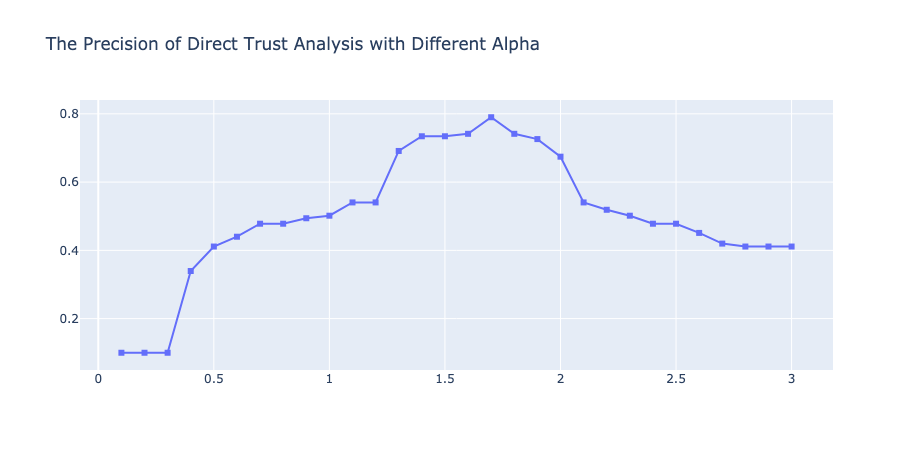

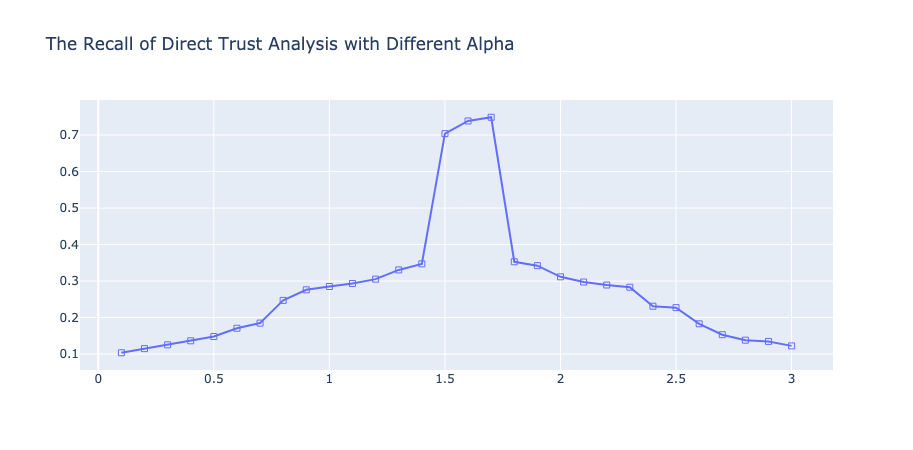

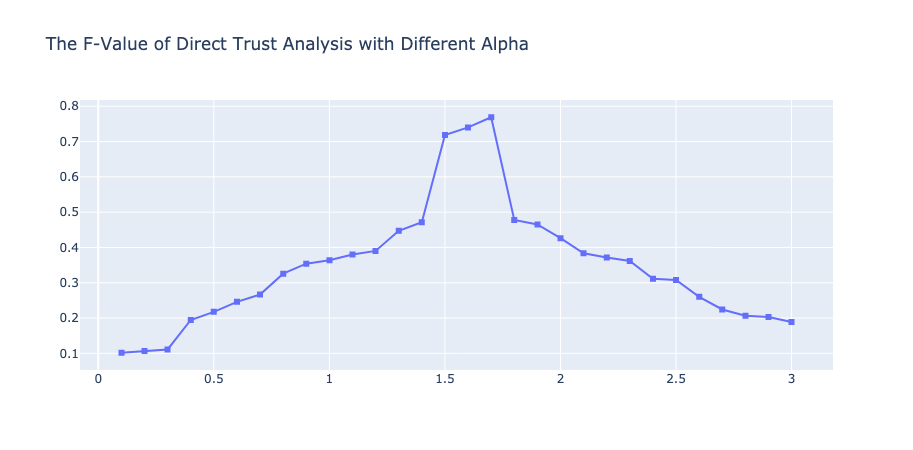

In [4]:
plot_different_alpha(dt_range=[0.07,0.08])

In [7]:
def plot_different_threshold(diff_list=np.arange(1,51,1)):  
    ap_conditions = ',\n'.join(
        ['IF(ABS(reviewer_tone-dt_tone)<{0},1,0) AS ap_{0}'.format(i)
         for i in diff_list])
    
    calc_conditions = ',\n'.join(
        ['SUM(IF(fact=1 AND ap_{0}=1,1,0)) AS tp_{0}, SUM(IF(fact=0 AND ap_{0}=1,1,0)) AS fp_{0}, SUM(IF(fact=1 AND ap_{0}=0,1,0)) AS fn_{0}'.format(i)
         for i in diff_list])
    
    prec_rec = ',\n'.join(
        ['tp_{0}/(tp_{0}+fp_{0}) AS p_{0}, tp_{0}/(tp_{0}+fn_{0}) AS r_{0}'.format(i)
         for i in diff_list])
    
    query = '''
    SELECT {2}
      FROM (SELECT {1}
              FROM (SELECT reviewerID, 
                           dt_reviewerID, 
                           fact,
                           {0}
                      FROM TABLE_NAME))
    '''.format(ap_conditions,
               calc_conditions,
               prec_rec)
    df = Query(query)
    
    t_df = df[[col for col in df.columns if col[:1]=='p']].T
    t_df.columns = ['precision']
    t_df.reset_index(inplace=True)
    t_df['recall'] = df[[col for col in df.columns if col[:1]=='r']].T[0].tolist()
    f_calc = lambda p,r: 2*p*r/(p+r)
    t_df['f_value'] = t_df[['precision','recall']].apply(lambda x: f_calc(*x), axis=1)
    
    def plot_scores(column):
        markers = {
            'precision':1,
            'recall':101, 
            'f_value':201}
        data = [go.Scatter(
            x=diff_list,
            y=t_df[column].tolist(),
            mode='lines+markers',
            marker={'symbol':markers[column]})]
        
        fig = go.Figure(
            data=data, 
            layout={'title':'The {0} of Direct Trust Analysis with Different LIWC Threshold'.format(column.replace('_','-').title())})
        iplot(fig)
        
    plot_scores('precision')
    plot_scores('recall')
    plot_scores('f_value')

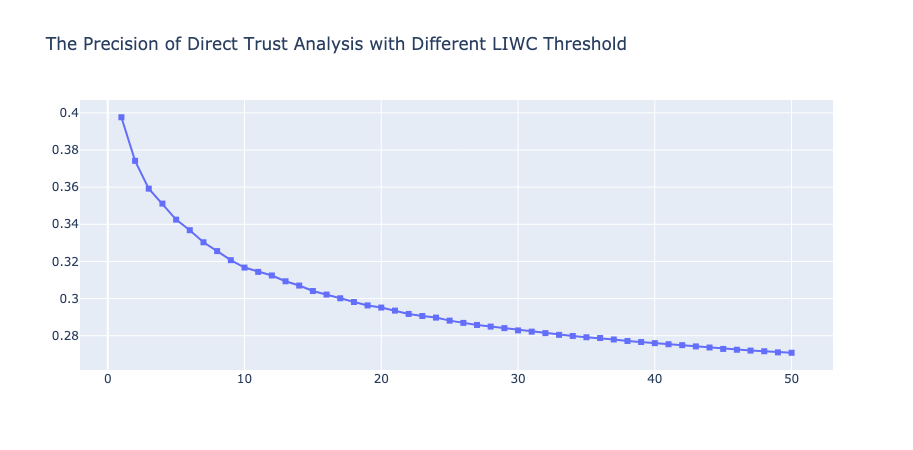

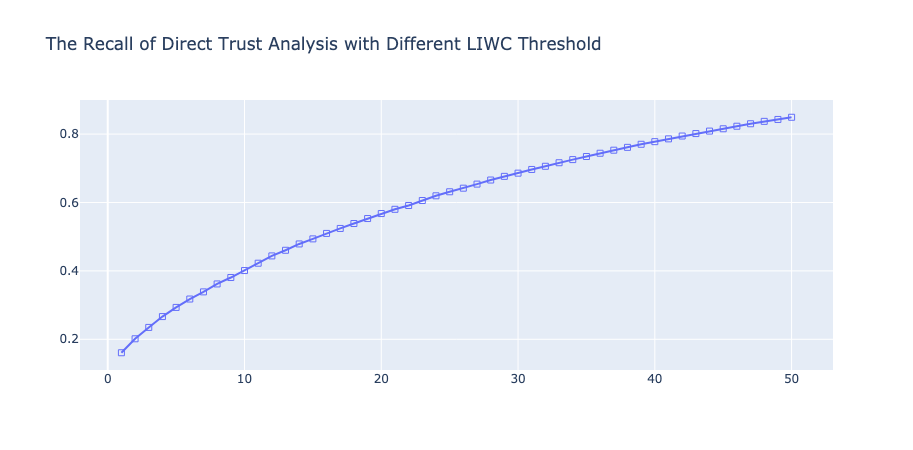

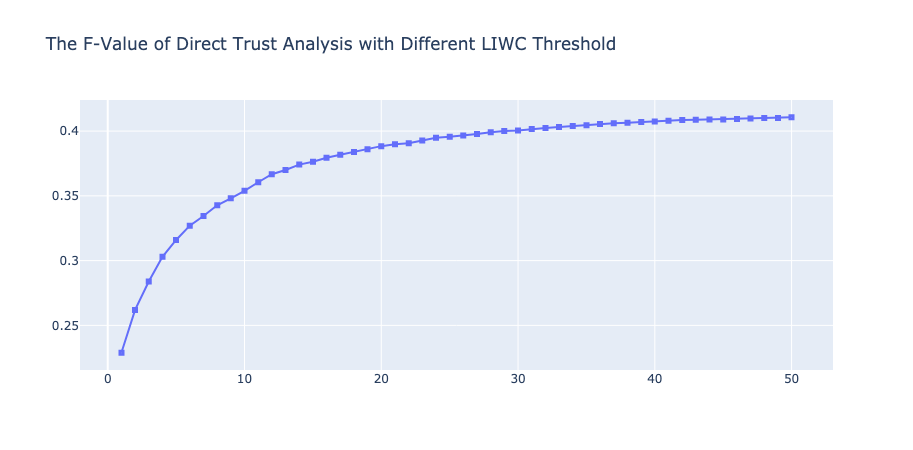

In [8]:
plot_different_threshold()